In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import spacy

from collections import Counter
from collections import defaultdict

# Uncomment the following lines if you want to use the freestylo package
'''
from freestylo import TextObject
from freestylo import TextPreprocessor
from freestylo.AlliterationAnnotation import AlliterationAnnotation
from freestylo.EpiphoraAnnotation import EpiphoraAnnotation
from freestylo.PolysyndetonAnnotation import PolysyndetonAnnotation
'''

import os
from tqdm import tqdm
import math
from math import log2
import re

import openai
from dotenv import load_dotenv

from sklearn.metrics import accuracy_score

## Load data and models

Models

In [2]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hadrienstrichard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nlp_fr = spacy.load("fr_core_news_sm") 

Data

In [4]:
texts = pd.read_parquet('../Data/excerpts_processed.parquet')

texts.head()

,Author,Title,URL,Excerpt_ID,Excerpt_Text,Cleaned_Text,Tokens
0,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_21,«--Hé! hé! monsieur Antoine; voulez-vous venir...,"""--hé! hé! monsieur antoine; voulez-vous venir...","[``, --, hé, !, hé, !, monsieur, antoine, ;, v..."
1,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_51,"«Cette demoiselle est fort taquine, pensa-t-il...","""cette demoiselle est fort taquine, pensa-t-il...","[``, cette, demoiselle, est, fort, taquine, ,,..."
2,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_50,"Mais l'accent, mais le regard, trouvent dans l...","mais l'accent, mais le regard, trouvent dans l...","[mais, l'accent, ,, mais, le, regard, ,, trouv..."
3,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_14,"--Qu'il s'en aille! et toi ... garde ta place,...","--qu'il s'en aille! et toi ... garde ta place,...","[--, qu'il, s'en, aille, !, et, toi, ..., gard..."
4,George Sand,Pauline,https://www.gutenberg.org/ebooks/12447,12447_11,"Mais, quoiqu'elle y mît de l'affection et de l...","mais, quoiqu'elle y mît de l'affection et de l...","[mais, ,, quoiqu'elle, y, mît, de, l'affection..."


In [5]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        3858 non-null   object
 1   Title         3858 non-null   object
 2   URL           3858 non-null   object
 3   Excerpt_ID    3858 non-null   object
 4   Excerpt_Text  3858 non-null   object
 5   Cleaned_Text  3858 non-null   object
 6   Tokens        3858 non-null   object
dtypes: object(7)
memory usage: 211.1+ KB


## Function words

In [6]:
# Load French function words (common stopwords in French) as our function word list.
french_function_words = set(stopwords.words('french'))
print(f"Number of French function words: {len(french_function_words)}")
# Optionally, inspect a few function words
print("Sample function words:", list(french_function_words)[:10])

Number of French function words: 157
Sample function words: ['ces', 'fussions', 'en', 'ai', 'eu', 'm', 'eurent', 'fussent', 'mes', 'eux']


In [7]:
# Define a set of punctuation marks we will consider for certain features.
punct_set = {'.', ',', ';', '!', '?', ':', '-', '—', '(', ')', '[', ']', '{', '}', '"', "'", '«', '»'}

In [8]:
# Compute total number of words (excluding punctuation) for each text, to use in normalization
texts['WordCount'] = texts['Tokens'].apply(lambda tokens: sum(1 for t in tokens if t not in punct_set))

# Add one feature column for each function word in the list
for fw in french_function_words:
    col_name = f"fw_{fw}"
    # Normalized frequency: count of fw divided by number of words (avoid division by zero)
    texts[col_name] = texts.apply(
        lambda row: row['Tokens'].count(fw) / row['WordCount'] if row['WordCount'] > 0 else 0.0,
        axis=1
    )

# Example: check a few function word feature columns for the first text
print(texts.loc[0, ['Author'] + [f"fw_{w}" for w in list(french_function_words)[:5]]])
print(texts.info())

/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

Author         George Sand
fw_ces            0.002466
fw_fussions            0.0
fw_en             0.011097
fw_ai                  0.0
fw_eu             0.000617
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 165 entries, Author to fw_auront
dtypes: float64(157), int64(1), object(7)
memory usage: 4.9+ MB
None


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(


In [9]:
# Define function word groups
func_word_groups = {
    "gfw_article": {"le", "la", "les", "un", "une", "du", "des"},
    "gfw_preposition": {"à", "de", "en", "dans", "avec", "sans", "sous", "sur", "chez"},
    "gfw_pronoun": {"je", "tu", "il", "elle", "nous", "vous", "ils", "elles", "on", "lui", "leur", "se", "me", "te", "moi", "toi", "qui", "que", "quoi"},
    "gfw_conjunction": {"et", "ou", "mais", "donc", "or", "car", "puisque", "lorsque", "parce", "que", "si"},
    "gfw_auxiliary": {"être", "avoir"}
}

# Compute per-group normalized frequencies
for group_name, word_set in func_word_groups.items():
    texts[group_name] = texts.apply(
        lambda row: sum(row['Tokens'].count(w) for w in word_set) / row['WordCount']
        if row['WordCount'] > 0 else 0.0, axis=1
    )

# Example: check the computed features for the first text
print(texts.loc[0, ['gfw_article', 'gfw_preposition', 'gfw_pronoun', 'gfw_conjunction', 'gfw_auxiliary']])

/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

gfw_article        0.063502
gfw_preposition    0.081998
gfw_pronoun        0.130086
gfw_conjunction    0.078298
gfw_auxiliary      0.003083
Name: 0, dtype: object


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(


In [10]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 170 entries, Author to gfw_auxiliary
dtypes: float64(162), int64(1), object(7)
memory usage: 5.0+ MB
None


## Pos tagging

In [11]:
# Define POS tags of interest
pos_tags = ['NOUN', 'PROPN', 'VERB', 'AUX', 'ADJ', 'ADV', 'PRON', 'DET', 'ADP', 'CCONJ', 'SCONJ', 'INTJ']

# Initialize POS frequency containers
pos_freqs = defaultdict(list)

for tokens in texts['Tokens']:
    doc = nlp_fr(" ".join(tokens))
    total_words = sum(1 for token in doc if token.pos_ != "PUNCT")
    
    pos_counts = Counter(token.pos_ for token in doc if token.pos_ != "PUNCT")
    pos_counts['NOUN'] += pos_counts.get('PROPN', 0)  # Merge PROPN into NOUN
    for pos in pos_tags:
        freq = pos_counts.get(pos, 0) / total_words if total_words > 0 else 0.0
        pos_freqs[pos].append(freq)

# Assign POS frequency features to the DataFrame
for pos in pos_tags:
    col = 'POS_' + ('NOUN' if pos == 'PROPN' else pos)
    if col not in texts.columns:
        texts[col] = pos_freqs[pos]
        
# Example: view the POS distribution for the first text


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col] = pos_freqs[pos]
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col] = pos_freqs[pos]
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_60788/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [12]:
print(texts.loc[0, ['Author'] + [f"POS_{w}" for w in pos_tags if w != 'PROPN']])

Author       George Sand
POS_NOUN        0.193326
POS_VERB        0.135788
POS_AUX         0.033947
POS_ADJ         0.055811
POS_ADV         0.097238
POS_PRON        0.164557
POS_DET          0.09954
POS_ADP          0.11565
POS_CCONJ       0.046605
POS_SCONJ       0.036824
POS_INTJ        0.000575
Name: 0, dtype: object


In [13]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 181 entries, Author to POS_INTJ
dtypes: float64(173), int64(1), object(7)
memory usage: 5.3+ MB
None


## Lexical features

In [14]:
def compute_lexical_metrics(token_list):
    # Remove punctuation and non-word tokens from the list
    words = []
    for token in token_list:
        if token in punct_set:
            continue  # skip punctuation tokens
        # Remove any punctuation attached to the token (e.g., apostrophes or hyphens) for word length calculation
        cleaned_token = re.sub(r'[\W_]+', '', token, flags=re.UNICODE)  # keep only alphanumeric characters
        if cleaned_token == "" or cleaned_token.isdigit():
            continue  # skip if token is empty or purely numeric after cleaning
        words.append(cleaned_token)
    if len(words) == 0:
        # If no valid word tokens, return zeros
        return pd.Series({"lex_TTR": 0.0, "lex_Hapax_Ratio": 0.0, "lex_AvgWordLen": 0.0})
    total_words = len(words)
    unique_words = set(words)
    # Type-Token Ratio
    ttr = len(unique_words) / total_words
    # Hapax Legomena Ratio
    word_freqs = Counter(words)
    hapax_count = sum(1 for count in word_freqs.values() if count == 1)
    hapax_ratio = hapax_count / total_words
    # Average word length (in characters)
    total_chars = sum(len(w) for w in words)
    avg_word_len = total_chars / total_words
    return pd.Series({"lex_TTR": ttr, "lex_Hapax_Ratio": hapax_ratio, "lex_AvgWordLen": avg_word_len})

# Apply the lexical metrics function to each text
lexical_df = texts['Tokens'].apply(compute_lexical_metrics)
# Merge the resulting metrics columns into the main DataFrame
texts = pd.concat([texts, lexical_df], axis=1)

# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'WordCount', 'lex_TTR', 'lex_Hapax_Ratio', 'lex_AvgWordLen']])
print(texts.info())


Author             George Sand
WordCount                 1622
lex_TTR               0.404537
lex_Hapax_Ratio       0.287335
lex_AvgWordLen        4.481411
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 184 entries, Author to lex_AvgWordLen
dtypes: float64(176), int64(1), object(7)
memory usage: 5.4+ MB
None


In [15]:
def compute_extended_lexical_metrics(token_list):
    words = []
    for token in token_list:
        if token in punct_set:
            continue
        cleaned_token = re.sub(r'[\W_]+', '', token, flags=re.UNICODE)
        if cleaned_token == "" or cleaned_token.isdigit():
            continue
        words.append(cleaned_token)

    if len(words) == 0:
        return pd.Series({
            "lex_YuleK": 0.0,
            "lex_SimpsonD": 0.0,
            "lex_Entropy": 0.0
        })

    word_counts = Counter(words)
    total = sum(word_counts.values())
    M1 = sum(v**2 for v in word_counts.values())
    yule_K = 10**4 * (M1 - total) / total**2
    simpson_D = sum((freq / total)**2 for freq in word_counts.values())
    entropy = -sum((freq / total) * log2(freq / total) for freq in word_counts.values())

    return pd.Series({
        "lex_YuleK": yule_K,
        "lex_SimpsonD": simpson_D,
        "lex_Entropy": entropy
    })

texts = texts.rename(columns={"WordCount": "lex_WordCount"})
texts = pd.concat([texts, texts['Tokens'].apply(compute_extended_lexical_metrics)], axis=1)

In [16]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'lex_WordCount', 'lex_YuleK', 'lex_SimpsonD', 'lex_Entropy']])
print(texts.info())

Author           George Sand
lex_WordCount           1622
lex_YuleK          82.046591
lex_SimpsonD        0.008835
lex_Entropy         8.202369
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 187 entries, Author to lex_Entropy
dtypes: float64(179), int64(1), object(7)
memory usage: 5.5+ MB
None


## Syntaxic features

In [17]:
def compute_syntaxic_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    pos_counts = Counter(token.pos_ for token in doc if token.pos_ != "PUNCT")
    nouns = pos_counts.get("NOUN", 0) + pos_counts.get("PROPN", 0)
    verbs = pos_counts.get("VERB", 0)
    adjs = pos_counts.get("ADJ", 0)
    advs = pos_counts.get("ADV", 0)

    syn_nom_verb = nouns / verbs if verbs > 0 else 0.0
    syn_adj_noun = adjs / nouns if nouns > 0 else 0.0
    syn_adv_verb = advs / verbs if verbs > 0 else 0.0

    sentence_lengths = [len([tok for tok in sent if not tok.is_punct]) for sent in doc.sents]
    complexity_deps = {"ccomp", "xcomp", "advcl", "relcl", "acl", "mark"}
    complexity_score = sum(1 for tok in doc if tok.dep_ in complexity_deps) / len(sentence_lengths) if sentence_lengths else 0.0

    avg_len = np.mean(sentence_lengths) if sentence_lengths else 0.0
    alternance_pattern = [1 if l > avg_len else 0 for l in sentence_lengths]
    switches = sum(1 for i in range(1, len(alternance_pattern)) if alternance_pattern[i] != alternance_pattern[i-1])
    alternance_rate = switches / len(alternance_pattern) if alternance_pattern else 0.0

    return pd.Series({
        "syn_Complexity": complexity_score,
        "syn_NomVerbRatio": syn_nom_verb,
        "syn_AdjNounRatio": syn_adj_noun,
        "syn_AdvVerbRatio": syn_adv_verb,
        "syn_AlternanceRate": alternance_rate
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_syntaxic_features)], axis=1)

In [18]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'syn_Complexity', 'syn_NomVerbRatio', 'syn_AdjNounRatio', 'syn_AdvVerbRatio', 'syn_AlternanceRate']])
print(texts.info())

Author                George Sand
syn_Complexity           2.095238
syn_NomVerbRatio         1.423729
syn_AdjNounRatio          0.28869
syn_AdvVerbRatio         0.716102
syn_AlternanceRate       0.485714
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 192 entries, Author to syn_AlternanceRate
dtypes: float64(184), int64(1), object(7)
memory usage: 5.7+ MB
None


## Punctuation

In [19]:
# Define a mapping of punctuation symbols to descriptive column names
punct_marks = {'.': 'Period', ',': 'Comma', ';': 'Semicolon', '?': 'QuestionMark', '!': 'ExclamationMark', ':': 'Colon'}

for symbol, name in punct_marks.items():
    texts[f"pun_{name}_Count"] = texts['Tokens'].apply(lambda tokens: tokens.count(symbol))

# Example: show punctuation counts for the first text
print(texts.loc[0, ['Author'] + [f"pun_{name}_Count" for name in punct_marks.values()]])


Author                       George Sand
pun_Period_Count                      33
pun_Comma_Count                      157
pun_Semicolon_Count                   16
pun_QuestionMark_Count                15
pun_ExclamationMark_Count             12
pun_Colon_Count                        5
Name: 0, dtype: object


In [20]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 198 entries, Author to pun_Colon_Count
dtypes: float64(184), int64(7), object(7)
memory usage: 5.8+ MB
None


## Dependencies

In [21]:
def compute_dep_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    deps = {"ccomp", "xcomp", "advcl", "relcl", "acl", "mark"}
    dep_counts = Counter(token.dep_ for token in doc)
    return pd.Series({f"dep_{d}": dep_counts.get(d, 0) for d in deps})

texts = pd.concat([texts, texts['Tokens'].apply(compute_dep_features)], axis=1)

In [22]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'dep_ccomp', 'dep_xcomp', 'dep_advcl', 'dep_relcl', 'dep_acl', 'dep_mark']])
print(texts.info())

Author       George Sand
dep_ccomp             29
dep_xcomp             54
dep_advcl             29
dep_relcl              0
dep_acl               11
dep_mark              97
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 204 entries, Author to dep_mark
dtypes: float64(184), int64(13), object(7)
memory usage: 6.0+ MB
None


## Sentence metrics

In [23]:
def compute_sentence_metrics_with_complexity(token_list):
    # Count sentence-ending punctuation marks
    sentence_enders = {'.', '!', '?'}
    
    # Count words (exclude all punctuation tokens)
    sent_count = sum(token_list.count(sym) for sym in sentence_enders)
    sent_count = max(sent_count, 1 if any(t not in punct_set for t in token_list) else 0)
    word_count = sum(1 for t in token_list if t not in punct_set)
    avg_sent_len = word_count / sent_count if sent_count > 0 else 0.0


    return pd.Series({
        "sent_Count": sent_count,
        "sent_AvgLength": avg_sent_len
    })

sentence_df = texts['Tokens'].apply(compute_sentence_metrics_with_complexity)
texts = pd.concat([texts, sentence_df], axis=1)

In [24]:
def compute_sentence_variation_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    sentences = list(doc.sents)
    sentence_lengths = [len([tok for tok in sent if not tok.is_punct]) for sent in sentences]
    sent_count = len(sentences)
    total_words = sum(sentence_lengths)

    avg_len = total_words / sent_count if sent_count > 0 else 0.0
    std_len = np.std(sentence_lengths) if sentence_lengths else 0.0
    min_len = min(sentence_lengths) if sentence_lengths else 0
    max_len = max(sentence_lengths) if sentence_lengths else 0

    passive_count = sum(
        1 for tok in doc
        if tok.dep_ == "aux:pass" or 
           (tok.head.lemma_ == "être" and tok.pos_ == "VERB" and "VerbForm=Part" in tok.morph)
    )

    intj_start = sum(1 for sent in sentences if len(sent) > 0 and sent[0].pos_ == "INTJ")
    questions = sum(1 for sent in sentences if any(tok.text == "?" for tok in sent))
    exclamations = sum(1 for sent in sentences if any(tok.text == "!" for tok in sent))

    return pd.Series({
        "sent_MinLength": min_len,
        "sent_MaxLength": max_len,
        "sent_StdLength": std_len,
        "sent_PassiveRatio": passive_count / sent_count if sent_count > 0 else 0.0,
        "sent_Interrogative": questions / sent_count if sent_count > 0 else 0.0,
        "sent_Exclamative": exclamations / sent_count if sent_count > 0 else 0.0,
        "sent_Exclamative_INTJ": intj_start / sent_count if sent_count > 0 else 0.0
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_sentence_variation_features)], axis=1)

In [25]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 213 entries, Author to sent_Exclamative_INTJ
dtypes: float64(193), int64(13), object(7)
memory usage: 6.3+ MB


## Verb Tenses

In [26]:
# Define tense/mood patterns to track
tense_patterns = {
    "tense_pres_ind": ("Tense=Pres", "Mood=Ind"),
    "tense_past_ind": ("Tense=Past", "Mood=Ind"),
    "tense_imp_ind": ("Tense=Imp", "Mood=Ind"),
    "tense_cond": ("Mood=Cnd",),
    "tense_subj": ("Mood=Sub",),
    "tense_inf": ("VerbForm=Inf",)
}

# Initialize dict of lists
tense_counts = {k: [] for k in tense_patterns.keys()}

for tokens in texts['Tokens']:
    doc = nlp_fr(" ".join(tokens))
    verb_tokens = [t for t in doc if t.pos_ in {"VERB", "AUX"}]
    total_verbs = len(verb_tokens)
    
    for label, conditions in tense_patterns.items():
        count = sum(
            all(cond in t.morph.to_json() for cond in conditions)
            for t in verb_tokens
        )
        tense_counts[label].append(count / total_verbs if total_verbs > 0 else 0.0)

# Add to DataFrame
for label, vals in tense_counts.items():
    texts[label] = vals


In [27]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 219 entries, Author to tense_inf
dtypes: float64(199), int64(13), object(7)
memory usage: 6.4+ MB
None


## Others

In [28]:
coord_conjs = {"et", "ou", "mais", "ni", "donc", "or", "car"}
subord_conjs = {"que", "quand", "si", "comme", "lorsque", "puisque", "bien que", "afin que", "parce que"}
discursive_markers = {"donc", "cependant", "toutefois", "néanmoins", "ainsi", "en effet", "or", "en revanche", "par conséquent", "en outre"}

def compute_discursive_features(token_list):
    coord_count = sum(1 for t in token_list if t.lower() in coord_conjs)
    subord_count = sum(1 for t in token_list if t.lower() in subord_conjs)
    disc_count = sum(1 for t in token_list if t.lower() in discursive_markers)
    ratio = subord_count / (coord_count + 1)
    return pd.Series({
        "syn_CoordCount": coord_count,
        "syn_SubordCount": subord_count,
        "syn_SubCoordRatio": ratio,
        "lex_MarkerCount": disc_count
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_discursive_features)], axis=1)

## Character Metrics

In [ ]:
# Commented out as it added too much features for too little gain

'''

def reconstruct_text(token_list):
    """Reconstruct text string from tokens, inserting spaces appropriately."""
    text = ""
    for token in token_list:
        if token in punct_set:
            # Attach punctuation directly to the text (no preceding space)
            text += token
        else:
            # If not the first token, add a space before adding the word
            if text:
                text += " "
            text += token
    return text

# List to collect n-gram frequency dictionaries for each text
char_ngram_features = []

for token_list in texts['Tokens']:
    text = reconstruct_text(token_list)
    # Initialize a dict for this text's n-grams
    ngram_counts = {}
    # Character bigrams (2-grams)
    for i in range(len(text) - 1):
        bigram = text[i:i+2]
        # Use an underscore to represent spaces in feature names for clarity
        feat_name = "bi_" + bigram.replace(" ", "_")
        ngram_counts[feat_name] = ngram_counts.get(feat_name, 0) + 1
    # Character trigrams (3-grams)
    for i in range(len(text) - 2):
        trigram = text[i:i+3]
        feat_name = "tri_" + trigram.replace(" ", "_")
        ngram_counts[feat_name] = ngram_counts.get(feat_name, 0) + 1
    char_ngram_features.append(ngram_counts)

# Convert list of dicts to DataFrame (each n-gram becomes a column, fill missing with 0)
char_ngram_df = pd.DataFrame(char_ngram_features).fillna(0).astype(int)
# Merge the n-gram features into the main DataFrame
texts = pd.concat([texts, char_ngram_df], axis=1)

# Example: number of character n-gram feature columns
print(f"Total character n-gram features: {char_ngram_df.shape[1]}")
# Show a small sample of character n-gram features for the first text
print(texts.loc[0, [col for col in texts.columns if col.startswith('bi_')][:5]])



'''



Total character n-gram features: 28205
bi_n'     20.0
bi_'e     37.0
bi_es    206.0
bi_st     32.0
bi_t_    201.0
Name: 0, dtype: object


## Figure of Speech Tagging

Avec freestylo

In [ ]:
#Commented out as it made the computer freeze

'''

FIGURES = [AlliterationAnnotation,
           EpiphoraAnnotation, PolysyndetonAnnotation]

def extract_stylistic_features(text, lang='fr', nlp=None):
    tobj = TextObject.TextObject(text=text, language=lang)
    tp = TextPreprocessor.TextPreprocessor(language=lang)
    tp.nlp = nlp
    tp.process_text(tobj)

    features, examples = {}, {}
    for AnnotClass in FIGURES:
        annot = AnnotClass(text=tobj)
        annot.find_candidates()
        if hasattr(annot, 'load_model'):
            annot.load_model()
        if hasattr(annot, 'score_candidates'):
            annot.score_candidates()

        instances = annot.candidates 
        features[f"fig_{AnnotClass.__name__}"] = len(instances)
        examples[AnnotClass.__name__] = instances
    return features, examples


def apply_stylistic_features(df, column='Cleaned_Text', nlp=None):
    feats_list, ex_list = [], []

    for txt in tqdm(df[column].astype(str), desc="Extracting stylistic features"):
        feats, ex = extract_stylistic_features(txt, nlp=nlp)
        feats_list.append(feats)
        ex_list.append(ex)

    feats_df = pd.DataFrame(feats_list).fillna(0).astype(int)
    return pd.concat([df.reset_index(drop=True), feats_df], axis=1), ex_list
    
texts, figure_examples = apply_stylistic_features(texts, nlp=nlp_fr)

texts['fig_AlliterationAnnotation', 'fig_EpiphoraAnnotation', 'fig_PolysyndetonAnnotation'].describe()
'''

LLM labeling

In [ ]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
def detect_figures(phrase: str) -> dict:
    prompt = f"""
Tu es un expert en analyse littéraire. Analyse la phrase suivante et indique quelles figures de style elle contient, en te basant sur cette liste. Pour chaque figure, réponds par vrai ou faux. Voici les figures à analyser, avec leur définition et un exemple pour chacune :

1. **Comparaison** : Mise en relation d’un comparé et d’un comparant avec un outil (comme, tel, semblable à, etc.).
   Exemple : « Cet homme est bête comme ses pieds »
2. **Métaphore** : Comparaison sans outil de comparaison.
   Exemple : « Ses cheveux de miel. »
3. **Personnification** : Attribution de caractéristiques humaines à un objet ou un animal.
   Exemple : « Le stylo saute de la table »
4. **Hyperbole** : Exagération dans le but de frapper l’imagination.
   Exemple : « Je meurs de faim »
5. **Litote** : Dire moins pour faire entendre plus.
   Exemple : « Je ne te hais point »
6. **Antithèse** : Opposition très forte entre deux idées.
   Exemple : « Je vis, je meurs »
7. **Oxymore** : Réunion de deux termes opposés dans un même groupe de mots.
   Exemple : « Une obscure clarté »
8. **Répétition** : Reprise d’un même mot plusieurs fois.
   Exemple : « La guerre, la guerre, la guerre ! »
9. **Énumération** : Accumulation de mots de même nature grammaticale.
   Exemple : « Il mange des pommes, des poires, des bananes et des kiwis. »
10. **Euphémisme** : Expression atténuée d’une idée jugée brutale.
   Exemple : « Il nous a quittés » (pour "il est mort")

Phrase à analyser :
« {phrase} »

Réponds uniquement avec un dictionnaire JSON contenant ces clés : "Comparaison", "Métaphore", "Personnification", "Hyperbole", "Litote", "Antithèse", "Oxymore", "Répétition", "Énumération", "Euphémisme", et pour chaque clé, la valeur `true` ou `false` (sans guillemets).

Ne donne pas d’explication.
    """

    response = openai.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=512
    )

    # Extraction de la sortie générée
    generated = response.choices[0].message.content

    # Évaluation sécurisée du JSON renvoyé (sans `eval`)
    import json
    try:
        result = json.loads(generated)
    except json.JSONDecodeError:
        print("Parsing error:", generated)
        result = {}

    return result

In [ ]:
detect_figures('Je ne te hais point')  # Example usage

{'Comparaison': False,
 'Métaphore': False,
 'Personnification': False,
 'Hyperbole': False,
 'Litote': True,
 'Antithèse': False,
 'Oxymore': False,
 'Répétition': False,
 'Énumération': False,
 'Euphémisme': False}

In [ ]:
# Test the LLM labeling function

# Load the test dataset
fig_df = pd.read_csv(
    "../Data/figures.csv",
    encoding="utf-8",
    sep=";",
)
print(len(fig_df))

# Normalize figure labels
fig_df["Figure"] = fig_df["Figure"].str.strip().str.capitalize()

# Store results
predicted_labels = []
correct_flags = []

# Loop through each sentence and evaluate
for i, row in tqdm(fig_df.iterrows(), total=len(fig_df), desc="Running LLM predictions"):
    sentence = row["Texte"]
    true_label = row["Figure"]

    result = detect_figures(sentence)

    # Store full prediction dictionary (optional)
    predicted_labels.append(result)

    # Check if the true label is among the ones flagged as True
    detected_true = result.get(true_label, False)
    correct_flags.append(detected_true)

# Add evaluation columns
fig_df["LLM_Output"] = predicted_labels
fig_df["Correct"] = correct_flags

# Compute accuracy
accuracy = fig_df["Correct"].mean()
print(f"\nAccuracy (relaxed): {accuracy:.2%}")

# Show errors (where the true label was not among the detected ones)
errors_df = fig_df[~fig_df["Correct"]]
print(f"\nTotal errors: {len(errors_df)} / {len(fig_df)}")

# Display mismatches
for idx, row in errors_df.iterrows():
    print("\n---")
    print(f"Sentence      : {row['Texte']}")
    print(f"True Label    : {row['Figure']}")
    print(f"LLM Prediction: {[k for k, v in row['LLM_Output'].items() if v]}")


28


Running LLM predictions: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Accuracy (relaxed): 96.43%

Total errors: 1 / 28

---
Sentence      : Candidese cacha du mieux qu’il put pendant cette boucherie héroïque.
True Label    : Oxymore
LLM Prediction: []


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hadrienstrichard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# List of target figures of speech
FIGURES = [
    "Comparaison", "Métaphore", "Personnification", "Hyperbole", "Litote",
    "Antithèse", "Oxymore", "Répétition", "Énumération", "Euphémisme"
]

def detect_figures_in_text(text, detection_function):
    """
    Tokenize the text into sentences and apply the detection function to each.
    Returns a dictionary of counts for each figure.
    """
    sentences = sent_tokenize(text, language='french')
    counts = {f"fig_{fig}": 0 for fig in FIGURES}

    for sentence in sentences:
        result = detection_function(sentence)
        for fig, detected in result.items():
            if detected:
                counts[f"fig_{fig}"] += 1
    return counts

def add_figure_counts_to_df(df, detection_function, text_column="Cleaned_Text"):
    """
    Applies figure detection to each row of the DataFrame and adds new feature columns.
    Each new column represents the number of times a figure was detected in that text.
    """
    tqdm.pandas()  # for progress bar
    figure_counts = df[text_column].progress_apply(lambda text: detect_figures_in_text(text, detection_function))
    figure_df = pd.DataFrame(list(figure_counts))
    return pd.concat([df, figure_df], axis=1)

In [ ]:
df_ex = add_figure_counts_to_df(texts[:1], detect_figures)

100%|██████████| 1/1 [01:03<00:00, 63.01s/it]


In [ ]:
df_ex.head()

,Author,Title,URL,Excerpt_ID,Excerpt_Text,Cleaned_Text,Tokens,fig_Comparaison,fig_Métaphore,fig_Personnification,fig_Hyperbole,fig_Litote,fig_Antithèse,fig_Oxymore,fig_Répétition,fig_Énumération,fig_Euphémisme
0,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_1,n'est souvent déterminée que par un mot. En ce...,n'est souvent déterminée que par un mot. en ce...,"[n'est, souvent, déterminée, que, par, un, mot...",4,2,1,1,4,6,1,0,10,1


## Final DF

In [29]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 223 entries, Author to lex_MarkerCount
dtypes: float64(203), int64(13), object(7)
memory usage: 6.6+ MB


In [30]:
# Taille du dataset
print("Shape:", texts.shape)

# Types de données
print(texts.dtypes.value_counts())

# Nombre total de valeurs manquantes
print("Missing values total:", texts.isna().sum().sum())

print(texts.isna().sum().sum() / (texts.shape[0] * texts.shape[1]) * 100, "% of total values are missing")


Shape: (3858, 223)
float64    203
int64       13
object       7
Name: count, dtype: int64
Missing values total: 0
0.0 % of total values are missing


In [31]:
# Étape 1 : Ne garder que les features + la colonne "Author"
# On supprime tout sauf "Author" et les colonnes de type numérique (features)
cols_to_keep = ['Author'] + [col for col in texts.columns if col not in ['Title', 'URL', 'Excerpt_ID', 'Excerpt_Text', 'Cleaned_Text', 'Tokens'] and col != 'Author']
texts = texts[cols_to_keep]

# Vérification
print("New shape after column filtering:", texts.shape)

# Étape 2 : Remplir les NaN par la moyenne PAR CLASSE (par 'Author')
# Cela suppose que toutes les colonnes sauf 'Author' sont numériques
feature_cols = [col for col in texts.columns if col != 'Author']

# On remplit les NaN par la moyenne des valeurs pour chaque auteur
texts[feature_cols] = texts.groupby('Author')[feature_cols].transform(lambda x: x.fillna(x.mean()))

# Vérification post-traitement
print("Total remaining NaNs:", texts.isna().sum().sum())


New shape after column filtering: (3858, 217)
Total remaining NaNs: 0


In [32]:
# Étape 1 : supprimer les colonnes avec uniquement des NaN
texts = texts.dropna(axis=1, how='all')

# Étape 2 : supprimer les colonnes avec uniquement des zéros (sauf colonne 'Author')
feature_cols = [col for col in texts.columns if col != 'Author']
zero_cols = [col for col in feature_cols if (texts[col] == 0).all()]

print(f"Nombre de colonnes entièrement nulles ou égales à zéro : {len(zero_cols)}")

# Drop them
texts.drop(columns=zero_cols, inplace=True)

# Vérification
print("Shape finale du dataset :", texts.shape)


Nombre de colonnes entièrement nulles ou égales à zéro : 9
Shape finale du dataset : (3858, 208)


In [33]:
texts.to_parquet("../Data/stylo_embedds.parquet", index=False)

In [34]:
# Extraire les préfixes avant le premier underscore
prefixes = texts.columns.str.extract(r'^([^_]+)_')[0]

# Remplacer les NaN (pas de préfixe) par "autre"
prefixes = prefixes.fillna("autre")

# Compter les occurrences de chaque préfixe (ou "autre")
prefix_counts = prefixes.value_counts()

print(prefix_counts)

# Filtrer les colonnes qui ne commencent PAS par "fw_"
non_fw_columns = [col for col in texts.columns if not col.startswith('fw_')]

# Afficher la liste
print(non_fw_columns)

0
fw       149
POS       11
sent       9
lex        8
syn        8
pun        6
tense      6
gfw        5
dep        5
autre      1
Name: count, dtype: int64
['Author', 'lex_WordCount', 'gfw_article', 'gfw_preposition', 'gfw_pronoun', 'gfw_conjunction', 'gfw_auxiliary', 'POS_NOUN', 'POS_VERB', 'POS_AUX', 'POS_ADJ', 'POS_ADV', 'POS_PRON', 'POS_DET', 'POS_ADP', 'POS_CCONJ', 'POS_SCONJ', 'POS_INTJ', 'lex_TTR', 'lex_Hapax_Ratio', 'lex_AvgWordLen', 'lex_YuleK', 'lex_SimpsonD', 'lex_Entropy', 'syn_Complexity', 'syn_NomVerbRatio', 'syn_AdjNounRatio', 'syn_AdvVerbRatio', 'syn_AlternanceRate', 'pun_Period_Count', 'pun_Comma_Count', 'pun_Semicolon_Count', 'pun_QuestionMark_Count', 'pun_ExclamationMark_Count', 'pun_Colon_Count', 'dep_advcl', 'dep_acl', 'dep_ccomp', 'dep_xcomp', 'dep_mark', 'sent_Count', 'sent_AvgLength', 'sent_MinLength', 'sent_MaxLength', 'sent_StdLength', 'sent_PassiveRatio', 'sent_Interrogative', 'sent_Exclamative', 'sent_Exclamative_INTJ', 'tense_pres_ind', 'tense_past_ind', 

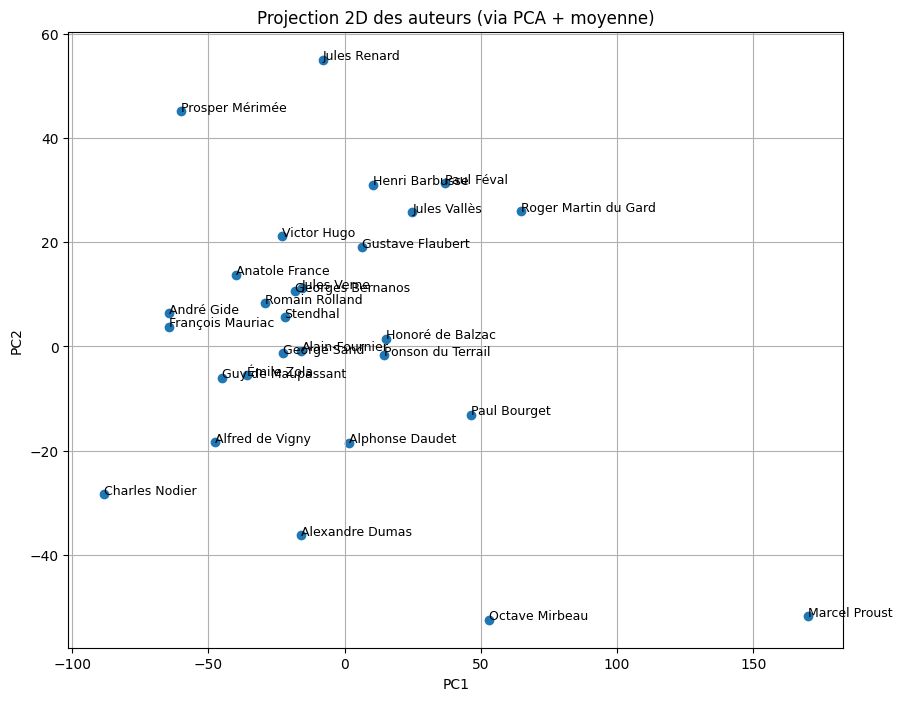

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = texts.copy()

# Supposons df est ton DataFrame
X = df.drop(columns=["Author"])
y = df["Author"]

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Créer un DataFrame avec les coordonnées PCA et l'auteur
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Author"] = y

# Moyenne des livres par auteur
author_centroids = df_pca.groupby("Author")[["PC1", "PC2"]].mean().reset_index()

# Affichage
plt.figure(figsize=(10, 8))
plt.scatter(author_centroids["PC1"], author_centroids["PC2"])

for _, row in author_centroids.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Author"], fontsize=9)

plt.title("Projection 2D des auteurs (via PCA + moyenne)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()